In [33]:
import json
import geojson
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.auto import tqdm
from pystac_client import Client
from geojson.utils import coords
from pyproj import Transformer
from shapely import wkt
from shapely.ops import transform
from shapely.geometry import Polygon, LinearRing
from odc.stac import stac_load
from IPython.display import Image

In [2]:
def bounds_to_ring(geom):
    minx, miny, maxx, maxy = geom.bounds
    return LinearRing([
        (minx, miny),
        (maxx, miny),
        (maxx, maxy),
        (minx, maxy),
        (minx, miny)
    ])


def load_geosjon(path: str) -> dict:
    with open(path, "r") as f:
        obj = geojson.load(f)
    return obj


def get_polygon_from_geometry(geometry: dict) -> Polygon:
    return Polygon(coords(geometry['coordinates']))


# def get_polygon_from_geometry(geometry: str) -> Polygon:
#     return wkt.loads(geometry)

In [3]:
filepath = "../geospatial/tests_01/data/archive/BR_Municipios_2020.shp"
gdf_municipios = gpd.read_file(filepath)

In [4]:
crs = "EPSG:4674"
gdf_municipios = gdf_municipios.to_crs(crs)

In [5]:
gdf_municipios['boundary'] = gdf_municipios.boundary
gdf_municipios["centroid"] = gdf_municipios.centroid
gdf_municipios["bounds"] = gdf_municipios.geometry.apply(bounds_to_ring)

/tmp/ipykernel_241015/3704606062.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_municipios["centroid"] = gdf_municipios.centroid


In [6]:
gdf_municipios.head(5)

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,boundary,centroid,bounds
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...","LINESTRING (-62.19465 -11.82746, -62.19332 -11...",POINT (-62.27466 -12.47013),"LINEARRING (-62.89408 -13.11894, -61.88651 -13..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...","LINESTRING (-62.53648 -9.73222, -62.52765 -9.7...",POINT (-62.95726 -9.95189),"LINEARRING (-63.61822 -10.28828, -62.42262 -10..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...","LINESTRING (-60.37119 -13.36655, -60.37134 -13...",POINT (-60.63981 -13.47488),"LINEARRING (-60.92476 -13.6937, -60.36529 -13...."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39...","LINESTRING (-61.0008 -11.29737, -61.00103 -11....",POINT (-61.32473 -11.30129),"LINEARRING (-61.7958 -11.61921, -61.00059 -11...."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0...","LINESTRING (-61.49976 -13.00525, -61.49809 -13...",POINT (-61.26095 -13.20356),"LINEARRING (-61.90804 -13.36371, -60.71665 -13..."


In [7]:
gdf_municipios['AREA_KM2'].nsmallest(10)

2911     3.565
3273     3.612
3812    15.331
3711    17.264
3550    17.449
1525    18.609
3221    19.393
1774    19.793
3855    20.388
1637    25.704
Name: AREA_KM2, dtype: float64

In [8]:
gdf = gdf_municipios.loc[[3812, 3711, 3550, 1774, 3221], ['CD_MUN', 'geometry']].reset_index(drop=True)
gdf.head(100)

,CD_MUN,geometry
0,3548807,"POLYGON ((-46.55698 -23.61209, -46.55694 -23.6..."
1,3539806,"POLYGON ((-46.35065 -23.50767, -46.35048 -23.5..."
2,3525003,"POLYGON ((-46.91529 -23.51394, -46.91525 -23.5..."
3,2802502,"POLYGON ((-36.98399 -10.68278, -36.98237 -10.6..."
4,3303203,"POLYGON ((-43.40291 -22.8003, -43.40187 -22.80..."


In [9]:
gdf_analysis = gdf[gdf['CD_MUN'] == '3548807'].reset_index()
gdf_analysis

,index,CD_MUN,geometry
0,0,3548807,"POLYGON ((-46.55698 -23.61209, -46.55694 -23.6..."


In [10]:
geom = json.loads(gdf['geometry'].to_json())['features'][0]['geometry']

In [11]:
polygon = get_polygon_from_geometry(geom)

transformer = Transformer.from_crs("urn:ogc:def:crs:OGC:1.3:CRS84", "EPSG:4326", always_xy=True)
polygon = transform(transformer.transform, polygon)

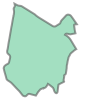

In [12]:
polygon

## Stac

In [13]:
CATALOG = "https://earth-search.aws.element84.com/v1/"
client = Client.open(CATALOG)

In [14]:
start_date = datetime(2025, 8, 10, 13, 20, 14).strftime("%Y-%m-%dT%H:%M:%S")
end_date = datetime(2025, 8, 24, 12, 30, 10).strftime("%Y-%m-%dT%H:%M:%S")

# start_date = datetime(2025, 3, 10).strftime("%Y-%m-%d")
# end_date = datetime(2025, 3, 30).strftime("%Y-%m-%d")

In [ ]:
search = client.search(
    collections=["sentinel-2-l2a"],
    datetime=f"{start_date}/{end_date}",
    bbox=polygon.bounds,
    sortby=[{"field": "properties.datetime", "direction": "asc"}],
)

items = list(search.items())
print(f"Found: {len(items):d} datasets")

Found: 3 datasets


In [27]:
collections = search.item_collection()
collections

In [20]:
# Image(collections[1].assets['thumbnail'].href)

In [23]:
item = items[0]

In [24]:
type(item)

pystac.item.Item

In [28]:
item_dict = item.to_dict()

In [29]:
item_dict.keys()

dict_keys(['type', 'stac_version', 'stac_extensions', 'id', 'geometry', 'bbox', 'properties', 'links', 'assets', 'collection'])

In [31]:
item_dict['properties']['datetime']

'2025-08-13T13:18:59.003000Z'

In [37]:
item_dict['properties']['datetime'][:10]

'2025-08-13'

In [ ]:
df_metadata = pd.DataFrame([item.to_dict() for item in items])

# path = f"s3://{const.S3_BUCKET_METADATA}/{const.S3_PREFIX_METADATA}/{const.SATELLITE_COLLECTION}/date={date_reference}/metadata.parquet"
# fs = S3FileSystem(anon=False)
# with fs.open(path, 'wb') as f:
#     df_metadata.to_parquet(f, index=False)

In [35]:
df_metadata.head(5)

,type,stac_version,stac_extensions,id,geometry,bbox,properties,links,assets,collection
0,Feature,1.0.0,[https://stac-extensions.github.io/processing/...,S2B_23KLP_20250813_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-46.9585...","[-46.973614, -24.499125, -45.883482, -23.497709]","{'created': '2025-08-13T16:27:15.597Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
1,Feature,1.0.0,[https://stac-extensions.github.io/view/v1.0.0...,S2C_23KLP_20250818_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-46.9585...","[-46.973614, -24.499125, -45.883482, -23.497709]","{'created': '2025-08-18T19:27:36.262Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
2,Feature,1.0.0,[https://stac-extensions.github.io/view/v1.0.0...,S2B_23KLP_20250823_0_L2A,"{'type': 'Polygon', 'coordinates': [[[-46.9585...","[-46.973614, -24.499125, -45.883482, -23.497709]","{'created': '2025-08-23T19:34:31.472Z', 'platf...","[{'rel': 'self', 'href': 'https://earth-search...",{'aot': {'href': 'https://sentinel-cogs.s3.us-...,sentinel-2-l2a
